In [16]:
import torch
from torch import nn
from d2l import torch as d2l

from function.generate_label import SS_data_label
from model.PS_Time_Net import get_model, get_loss

from tqdm.notebook import tqdm

from utils import get_logger, load_checkpoint, save_checkpoint, Metric, picker_cor

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import numpy as np


In [17]:
## define the test function
# test function
def test(model, test_dataset, threshold, criterion, num_gpus, thresholds):

    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    model = nn.DataParallel(model, device_ids=devices)

    model.eval()
    metrics = {
        'detection':Metric(error_flag=False),
        'SS_picking':Metric(error_flag=True)}
    
    N = len(test_dataset)
    
    SS_predict = []
    d_predict = []
    sac_name = []
    correlation = []
    SS_hand = []

    with torch.no_grad():
        all_loss = 0.0
        with tqdm(range(0,N,1), total=N, smoothing=0.9) as tqdmUpdate:
            for i in tqdmUpdate:
                x, (SS,dection,polarity_label,sacname) = test_dataset.__getitem__(i)
                sacname = sacname.decode().strip()

                if polarity_label == 1:
                    x = x*1
                elif polarity_label == 2:
                    x = x*(-1)

                x = torch.Tensor(x).to(devices[0]).unsqueeze(0)
                SS = torch.Tensor(SS).to(devices[0]).unsqueeze(0)
                d = torch.Tensor(dection).to(devices[0])
                d = d.reshape(-1,8000)
                preds = model(x)
                targets = (SS, d)
                loss = criterion(preds, targets)
                all_loss += loss.item()

                SS, d = [pred[0].cpu().numpy() for pred in preds]
                
                matches, cor = picker_cor(SS, d, 8000, thresholds) 
                correlation.append(cor)
                
                match_detect = None
                match_ss = None
                NN = len(matches)
                if NN > 1:
                    for ii in range(0,NN,1):
                        if 'detection' in matches[ii]:
                            match_detect = matches[ii]
                        if 'ss' in matches[ii]:
                            match_ss = matches[ii]
                elif NN == 1:
                    if 'detection' in matches[0]:
                        match_detect = matches[0]
                    elif 'ss' in matches[0]:
                        match_ss = matches[0]
                
                if match_detect:
                    d_predict.append(match_detect['detection'])
                else:
                    d_predict.append([0, 0, 0])

                if match_ss:
                    SS_predict.append(match_ss['ss'])
                else:
                    SS_predict.append([0, 0])

                sac_name.append(sacname)

                SS = test_dataset.SS_labels[i]
                SS_hand.append(SS)        

    loss_ave = all_loss/N

    return metrics, SS_predict, d_predict, sac_name, loss_ave, correlation, SS_hand

In [18]:
from datetime import datetime

def d_to_jd(time):
    fmt = '%Y.%m.%d'
    dt = datetime.strptime(time, fmt)
    tt = dt.timetuple()
    return tt.tm_year * 1000 + tt.tm_yday

def jd_to_time(time):
    dt = datetime.strptime(time, '%Y%j').date()
    fmt = '%Y.%m.%d'
    return dt.strftime(fmt)

# print(jd_to_time('2019100'))

In [19]:
import numpy as np
import os
from matplotlib import pyplot as plt


threshold = 10 # 0.5 seconds
thresholds = [0.5, 0.1, 0.0001]

model = get_model().cuda()
model.load_state_dict(torch.load('./checkpoints/net_params.pth'))

data_root = '../data'

model.eval()

testset = SS_data_label(data_root, 'test', 8000, 1, 'gaussian')

devices = d2l.try_all_gpus()
num_gpus = len(devices)
criterion = get_loss()


devices = [d2l.try_gpu(i) for i in range(num_gpus)]
model = nn.DataParallel(model, device_ids=devices)

model.eval()
metrics = {
    'detection':Metric(error_flag=False),
    'SS_picking':Metric(error_flag=True)}

N = len(testset)

x_all = []
SS_predict = []
d_predict = []
sac_name = []
correlation = []
SS_hand = []
evt_time = []

with torch.no_grad():
    
    for i in range(0,N,1):
        # print(i)
        x, (SS,dection,polarity_label,sacname) = testset.__getitem__(i)
        sacname = sacname.decode().strip()
        # print(polarity_label)
        if polarity_label == 1:
            x = x*1
        elif polarity_label == 2:
            x = x*(-1)

        x = torch.Tensor(x).to(devices[0]).unsqueeze(0)
        SS = torch.Tensor(SS).to(devices[0]).unsqueeze(0)
        d = torch.Tensor(dection).to(devices[0])
        d = d.reshape(-1,8000)
        preds = model(x)

        SS_pred, d_pred = [pred[0].cpu().numpy() for pred in preds]
        SS_predict.append(SS_pred)
        d_predict.append(d_pred)
        x_all.append(x.cpu()[0][0].numpy())

        sac_name.append(sacname)
        SS_hand_ = testset.SS_labels[i]
        SS_hand.append(SS)

        year = sacname[0:4]
        day = sacname[5:8]
        hour = sacname[9:11]
        min = sacname[12:14]
        sec = sacname[15:17]
        date = jd_to_time(year+day)
        time = hour+':'+min+':'+sec
        evt_time.append(date+' '+time)
        # print(date+' '+time)



In [20]:
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['font.family'] = 'Times New Roman' # 统一设置字体
plt.rcParams['xtick.labelsize'] = 12 # 统一设置轴刻度标签的字体大小
plt.rcParams['ytick.labelsize'] = 12 

plt.rcParams['axes.labelsize'] = 12 # 统一设置xy轴名称的字体大小

plt.rcParams['axes.titlesize'] = 14

print(plt.rcParams['font.family'])

['Times New Roman']


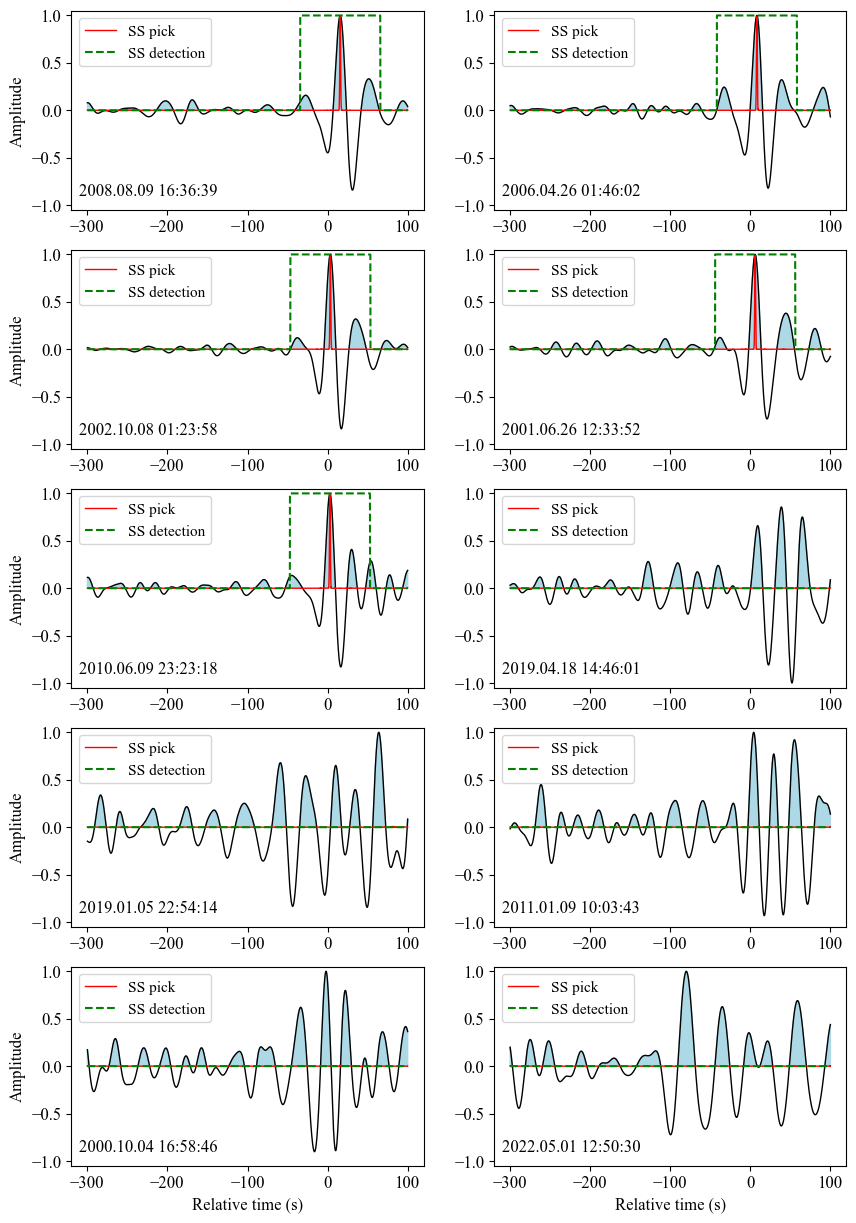

In [22]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(5, 2)
fig.set_size_inches(10, 15)
axes_list = []
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes_list.append(axes[i, j])


for n, ax in enumerate(axes_list):
    data = x_all[n]
   
    # t = np.arange(0,len(data),1)
    t = np.linspace(-300,100,8000,endpoint=False)
    ax.plot(t, data,'k',linewidth=1)
    ax.fill_between(t, data, 0, where=(data > 0), color='lightblue', interpolate=True)
    # ax.fill_between(t, data, 0, where=(data < 0), color='blue', interpolate=True)
    
    ax.plot(t, SS_predict[n],'r',linewidth=1,label='SS pick')
    ax.plot(t, d_predict[n],'g--',linewidth=1.5,label='SS detection')

    ax.text(-310, -0.9, evt_time[n], fontsize=12)
    ax.set_xticks([-300, -200, -100, 0, 100])
    if n > 7:
       ax.set_xlabel('Relative time (s)')

    ax.set_ylim(-1.05,1.05)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    if n == 0 or n == 2 or n==4 or n==6 or n==8:
        ax.set_ylabel('Amplitude')

    ax.legend(loc='upper left', fontsize=11)

plt.show()